In [ ]:
pip install scikeras

In [ ]:
pip install opencv-python

In [ ]:
!pip install tensorflow

In [1]:
import pandas as pd
import numpy as np
import os
import shutil
import splitfolders
import matplotlib.pyplot as plt
from skimage import transform, io
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import InceptionV3, ResNet152, InceptionResNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from scikeras.wrappers import KerasClassifier

from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, roc_auc_score,roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import GridSearchCV

import re
import cv2
from PIL import Image

In [2]:
df = pd.read_csv(r"C:\Users\n1109899\Downloads\aptos2019-blindness-detection\train.csv", delimiter=",")
df.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [3]:
# Retriving the class list
class_list = df["diagnosis"].unique()
class_list = [int(item) for item in class_list if not np.isnan(item)]
class_list = sorted(class_list)
class_list

[0, 1, 2, 3, 4]

## Load and Split dataset

In [4]:
# specify image folder
image_folder = 'train_images'
extension = '.png'

In [5]:
# check for dublicates
df.duplicated().sum()

0

In [6]:
# get label df columns
df.columns

Index(['id_code', 'diagnosis'], dtype='object')

In [22]:
# order and load all images and labels into arrays
train_ = []
label_ = []
data = []
dims = 299
for image in df["id_code"]:
    image_file = cv2.imread(os.path.join(image_folder,image+extension))
    #image_file = cv2.resize(image_file,(dims,dims))
    idx = df["id_code"].tolist().index(image)
    label = df["diagnosis"][idx]
    
    train_.append(image_file)
    label_.append(label)

train_set = np.array(train_)
train_label = np.array(label_)

C:\Users\n1109899\AppData\Local\Temp/ipykernel_11312/182509564.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_set = np.array(train_)


In [46]:
X_train1,X_test,y_train1,y_test = train_test_split(train_set,train_label,test_size=0.2, shuffle = True, random_state=42)

In [47]:
X_train, X_val, y_train, y_val = train_test_split(X_train1, y_train1, test_size = 0.2, shuffle = True, random_state = True)

In [48]:
X_train.shape,X_test.shape, X_val.shape

((2343,), (733,), (586,))

In [49]:
y_train.shape,y_test.shape, y_val.shape

((2343,), (733,), (586,))

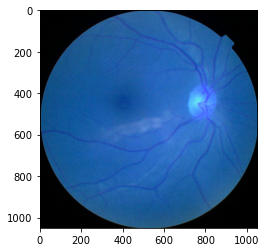

In [50]:
plt.imshow(X_val[76])

## Augment train set

In [51]:
def adjust_contrast(image):
    return tf.image.adjust_contrast(image,2)

def adjust_brightness(image):
    return tf.image.adjust_brightness(image,0.2)

def adjust_saturation(image):
    return tf.image.adjust_saturation(image,10)

def adjust_hue(image):
    return tf.image.adjust_hue(image,-0.1)

def adjust_flip(image):
    return tf.image.random_flip_left_right(image)

In [52]:
augmentations = [adjust_contrast,adjust_brightness,adjust_saturation,adjust_hue,adjust_flip]

In [53]:
def random_augmentation(data):
    augmented_images = []
    
    for index, image in enumerate(data):
        random_augmentation = random.choice(augmentations)
        aug_img = random_augmentation(image)
        
        index = index + 1
        
        if ((index % 2) == 0):
            aug_img = np.array(random_augmentation(image))
            augmented_images.append(aug_img)
        else:
            augmented_images.append(image)
    return augmented_images

In [54]:
X_train = random_augmentation(X_train) # This is a list for now

In [44]:
X_train = np.array(X_train)

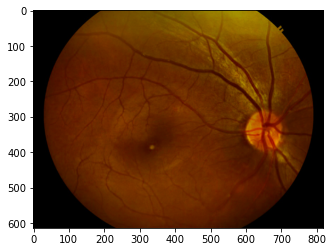

In [55]:
temp = cv2.cvtColor(X_train[45], cv2.COLOR_BGR2RGB)
plt.imshow(temp)
plt.show()

### Resize and Rescale

In [56]:
def resizeImages(images):
    resized_aug_images = []
    for img in images:
        img = cv2.resize(img,(299,299))

        resized_aug_images.append(img)
    return resized_aug_images

In [57]:
X_train = resizeImages(X_train)
X_train = np.array(X_train)

In [60]:
X_train.shape

(2343, 299, 299, 3)

In [61]:
X_val = resizeImages(X_val)
X_val = np.array(X_val)

In [62]:
X_test = resizeImages(X_test)
X_test = np.array(X_test)
X_test.shape

(733, 299, 299, 3)

In [64]:
# function to scale images
def scale(dataset):
    factor = 255.0
    dataset = dataset/factor
    return dataset

In [65]:
# scale images
X_train= scale(X_train)
X_val = scale(X_val)
X_test = scale(X_test)

## Evaluation functions

In [67]:
# Accuracy and Loss curves
def plot_acc_loss(model_history):
    train_acc = model_history.history['accuracy']
    val_acc = model_history.history['val_accuracy']

    train_loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']

    plt.figure(figsize=(10, 3))
    plt.subplot(1, 2, 1)
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.show()

In [68]:
# display confusion matrix heatmap
def confusion_heatmap(cm):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    fig, ax = plt.subplots(figsize=(7,4), dpi=100)
    ax.set(title='Confusion Matrix for the InceptionV3 model')
    disp.plot(ax = ax)
    plt.show()

In [69]:
# calculate weighted_average specificity
def weighted_average_specificity(cm):
    num_classes = 5
    class_counts = []

    for class_label in range(num_classes):
        # Create  binary classification for the current class
        binary_test = [1 if label == class_label else 0 for label in y_test]
         # Count the number of samples for the current class
        class_counts.append(sum(binary_test))
    print(class_counts)   

    fp = cm.sum(axis=0) - np.diag(cm)  
    fn = cm.sum(axis=1) - np.diag(cm)
    tp = np.diag(cm)
    tn = cm.sum() - (fp + fn + tp)
    specificity = tn/(tn+fp) 

    specificity = np.average(specificity, weights = class_counts)
    return specificity

In [70]:
# calculate macro_average specificity
def macro_average_specificity(cm):

    fp = cm.sum(axis=0) - np.diag(cm)  
    fn = cm.sum(axis=1) - np.diag(cm)
    tp = np.diag(cm)
    tn = cm.sum() - (fp + fn + tp)
    specificity = tn/(tn+fp) 

    specificity =np.mean(specificity)
    return specificity

In [71]:
# Calculate the micro-average AUC
def micro_average_auc(y_pred):
    
    micro_avg_auc = roc_auc_score(y_test, y_pred, multi_class='ovr')
    return micro_avg_auc



In [72]:
# roc curve
def roc_plot(y_pred):

# Binarize actual test labels 
    y_test_cat = label_binarize(y_test, classes=np.arange(num_classes))

    # Compute the ROC curve and AUC for the micro-average
    fpr, tpr, _ = roc_curve(y_test_cat.ravel(), y_pred.ravel())
   
    # Plot the micro-average ROC curve
    plt.figure(figsize=(6, 4))
    
    plt.plot(fpr, tpr, color='deeppink', linestyle='-', lw=1)         

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Micro-Average Receiver Operating Characteristic (ROC) Curve')
    plt.show()


## Model Development and Training

In [73]:
# function to build model
def build_model(pre_trained_network):
    base_model = pre_trained_network(weights = 'imagenet', include_top = False, input_shape = (dims,dims,colour_channel))
    
    for layers in base_model.layers:
        layers.trainable = False

    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(dropout))
    model.add(Dense(num_classes, activation = 'softmax'))
    print(model.summary())
    
    #compile model
    #specify optimizer, loss and earlytopping
    adam = tf.keras.optimizers.Adam(learning_rate = lr)
    loss = tf.keras.losses.SparseCategoricalCrossentropy()

    model.compile(optimizer = adam, loss = loss, metrics = METRICS)
    
    return model

In [74]:
colour_channel =3
epochs = 50
lr = 0.001
METRICS=['accuracy']
batch_size = 32
patience = 10
num_classes = 5
dropout = 0.5
callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = patience)

### Build and train model 1 - Inception V3

In [75]:
InceptionV3_model = build_model(InceptionV3)

87910968/87910968 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 5)                 10245     
                                                                 
Total params: 21813029 (83.21 MB)
Trainable params: 10245 (40.02 KB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________
None


In [77]:
InceptionV3_model_history = InceptionV3_model.fit(X_train, y_train, batch_size = batch_size, epochs = epochs, validation_data =(X_val, y_val) , callbacks = [callback])
                                            

Epoch 1/50
74/74 [==============================] - 79s 1s/step - loss: 1.1462 - accuracy: 0.6018 - val_loss: 0.8335 - val_accuracy: 0.7048
Epoch 2/50
74/74 [==============================] - 77s 1s/step - loss: 0.8668 - accuracy: 0.6897 - val_loss: 0.7411 - val_accuracy: 0.7270
Epoch 3/50
74/74 [==============================] - 76s 1s/step - loss: 0.7654 - accuracy: 0.7209 - val_loss: 0.6832 - val_accuracy: 0.7406
Epoch 4/50
74/74 [==============================] - 77s 1s/step - loss: 0.7322 - accuracy: 0.7286 - val_loss: 0.6537 - val_accuracy: 0.7491
Epoch 5/50
74/74 [==============================] - 75s 1s/step - loss: 0.7015 - accuracy: 0.7345 - val_loss: 0.6452 - val_accuracy: 0.7594
Epoch 6/50
74/74 [==============================] - 75s 1s/step - loss: 0.6722 - accuracy: 0.7529 - val_loss: 0.6359 - val_accuracy: 0.7509
Epoch 7/50
74/74 [==============================] - 79s 1s/step - loss: 0.6470 - accuracy: 0.7516 - val_loss: 0.6058 - val_accuracy: 0.7662
Epoch 8/50
74/74 [==

In [78]:
# save model
InceptionV3_model.save('aug_unprocessed_InceptionV3_model1.h5')

C:\ProgramData\Anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


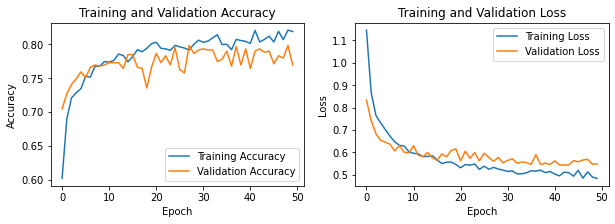

In [79]:
plot_acc_loss(InceptionV3_model_history)

### Evaluate Inception model 

In [80]:
# Predict on test set
inceptionv3_y_pred = InceptionV3_model.predict(X_test)

23/23 [==============================] - 19s 769ms/step


In [81]:
# Classification report
inceptionv3_y_pred_labels = np.argmax(inceptionv3_y_pred, axis=1)
print(classification_report(y_test, inceptionv3_y_pred_labels))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       351
           1       0.42      0.54      0.47        68
           2       0.68      0.72      0.70       213
           3       0.57      0.22      0.32        36
           4       0.38      0.22      0.27        65

    accuracy                           0.76       733
   macro avg       0.60      0.54      0.54       733
weighted avg       0.74      0.76      0.74       733



In [82]:
# Confusion matrix
inceptionv3_conf_matrix = confusion_matrix(y_test, inceptionv3_y_pred_labels)

inceptionv3_conf_matrix

array([[341,   8,   2,   0,   0],
       [ 12,  37,  16,   0,   3],
       [ 12,  32, 154,   2,  13],
       [  0,   5,  16,   8,   7],
       [  2,   6,  39,   4,  14]], dtype=int64)

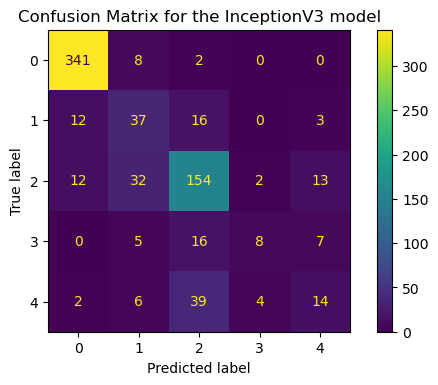

In [83]:
# confusion matrix
confusion_heatmap(inceptionv3_conf_matrix)

In [84]:
# weighted average specificity
inception_wa_specificity = weighted_average_specificity(inceptionv3_conf_matrix)
print(inception_wa_specificity)

[351, 68, 213, 36, 65]
0.9160232789241356


In [85]:
inception_ma_specificity = macro_average_specificity(inceptionv3_conf_matrix)
print(inception_ma_specificity)

0.9343642737930127


In [86]:
micro_avg_auc = micro_average_auc(inceptionv3_y_pred)
print("Micro-Average AUC:", micro_avg_auc)


Micro-Average AUC: 0.8994897408443279


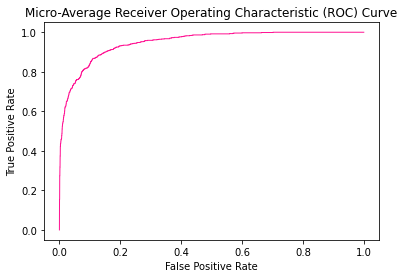

In [87]:
roc_plot(inceptionv3_y_pred)

## Build and train model 2 - ResNet152

In [88]:
# build and compile model
resnet152_model = build_model(ResNet152)

234698864/234698864 [==============================] - 9s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152 (Functional)      (None, 10, 10, 2048)      58370944  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 5)                 10245     
                                                                 
Total params: 58381189 (222.71 MB)
Trainable params: 10245 (40.02 KB)
Non-trainable params: 58370944 (222.67 MB)
_________________________________________________________________
None


In [ ]:
# fit resnet model
resnet152_model_history = resnet152_model.fit(X_train, y_train, batch_size = batch_size, epochs = epochs, validation_data =(X_val, y_val) ,shuffle= True, callbacks = [callback])


Epoch 1/50
74/74 [==============================] - 334s 4s/step - loss: 1.6178 - accuracy: 0.4213 - val_loss: 1.2717 - val_accuracy: 0.4710
Epoch 2/50
74/74 [==============================] - 337s 5s/step - loss: 1.4135 - accuracy: 0.4622 - val_loss: 1.2436 - val_accuracy: 0.4710
Epoch 3/50
74/74 [==============================] - 322s 4s/step - loss: 1.3070 - accuracy: 0.5100 - val_loss: 1.1815 - val_accuracy: 0.5341
Epoch 4/50
74/74 [==============================] - 337s 5s/step - loss: 1.2822 - accuracy: 0.5288 - val_loss: 1.1458 - val_accuracy: 0.6655
Epoch 5/50
74/74 [==============================] - 354s 5s/step - loss: 1.2351 - accuracy: 0.5523 - val_loss: 1.1085 - val_accuracy: 0.5904
Epoch 6/50
74/74 [==============================] - 338s 5s/step - loss: 1.2068 - accuracy: 0.5625 - val_loss: 1.1417 - val_accuracy: 0.5444
Epoch 7/50
74/74 [==============================] - 332s 5s/step - loss: 1.1644 - accuracy: 0.5839 - val_loss: 1.1391 - val_accuracy: 0.5324
Epoch 8/50
74

In [ ]:
# save model
resnet152_model.save('aug_unprocessed_ResNet152_model.h5')

plot_acc_loss(resnet152_model_history)

### Evaluate ResNet152 model

In [ ]:
# Predict on test set
resnet152_y_pred = resnet152_model.predict(X_test)

In [ ]:
# Classification report
resnet152_y_pred_labels = np.argmax(resnet152_y_pred, axis=1)
print(classification_report(y_test, resnet152_y_pred_labels))

In [ ]:
# Confusion matrix
resnet152_conf_matrix = confusion_matrix(y_test, resnet152_y_pred_labels)

print(resnet152_conf_matrix)

In [ ]:
# confusion matrix heatmap
confusion_heatmap(resnet152_conf_matrix)

In [ ]:
# weighted average specificity
resnet152_wa_specificity = weighted_average_specificity(resnet152_conf_matrix)
print(resnet152_wa_specificity)

In [ ]:
# macro avg specificity
resnet152_ma_specificity = macro_average_specificity(resnet152_conf_matrix)
print(resnet152_ma_specificity)

In [ ]:
# micro_avg AUC
micro_avg_auc = micro_average_auc(resnet152_y_pred)
print("ResNet152 Micro-Average AUC:", micro_avg_auc)


In [ ]:
roc_plot(resnet152_y_pred)

## Build and train model 3 - InceptionResNetV2

In [ ]:
# build anad compile model
inceptionResnet_model = build_model(InceptionResNetV2)

In [ ]:
# fit resnet model
inceptionResnet_model_history = inceptionResnet_model.fit(X_train, y_train, batch_size = batch_size, epochs = epochs, validation_data =(X_val, y_val) ,shuffle= True, callbacks = [callback])


In [ ]:
# save model
inceptionResnet_model.save('aug_processed_inceptionResnet_model.h5')

In [ ]:
# plot loss and accuracy
plot_acc_loss(inceptionResnet_model_history)

### Evaluate InceptionResNetV2 model

In [ ]:
# Predict on test set
inceptionResnet_y_pred = inceptionResnet_model.predict(X_test)

In [ ]:
# Classification report
inceptionResnet_y_pred_labels = np.argmax(inceptionResnet_y_pred, axis=1)
print(classification_report(y_test, inceptionResnet_y_pred_labels))

In [ ]:
# Confusion matrix
inceptionResnet_conf_matrix = confusion_matrix(y_test, inceptionResnet_y_pred_labels)

print(inceptionResnet_conf_matrix)

In [ ]:
# confusion matrix heatmap
confusion_heatmap(inceptionResnet_conf_matrix)

In [ ]:
# weighted average specificity
inceptionResnet_wa_specificity = weighted_average_specificity(inceptionResnet_conf_matrix)
print(inceptionResnet_wa_specificity)

In [ ]:
# macro avg specificity
inceptionResnet_ma_specificity = macro_average_specificity(inceptionResnet_conf_matrix)
print(inceptionResnet_ma_specificity)

In [ ]:
# micro_avg AUC
micro_avg_auc = micro_average_auc(inceptionResnet_y_pred)
print("InceptionResNet Micro-Average AUC:", micro_avg_auc)


In [ ]:
roc_plot(inceptionResnet_y_pred)

## Adaboost

In [92]:
model1 = InceptionResNetV2_model1
model2 = Inception_model1

In [93]:
models = [model1, model2]

In [125]:
preds = [model.predict(X_test) for model in models]

23/23 [==============================] - 24s 1s/step


In [135]:
pred = np.array(preds)

In [129]:
summed = np.sum(pred3, axis=0)

In [131]:
# argmax across classes
ensemble_prediction = np.argmax(summed, axis=1)

In [115]:
prediction1 = np.array(model1.predict(X_test))
prediction2 = np.array(model2.predict(X_test))

23/23 [==============================] - 24s 1s/step


In [122]:
accuracy1 = np.argmax(prediction1, axis=1)
accuracy2 = np.argmax(prediction2, axis=1)

In [137]:
accuracy1 = accuracy_score(y_test, accuracy1)
accuracy2 = accuracy_score(y_test, accuracy2 )
ensemble_accuracy = accuracy_score(y_test, ensemble_prediction)

In [112]:
print('Accuracy Score for average ensemble = ', ensemble_accuracy)

Accuracy Score for average ensemble =  0.7680763983628922


In [138]:
print('Accuracy Score for model2 = ', accuracy1)
print('Accuracy Score for model3 = ', accuracy2)
print('Accuracy Score for average ensemble = ', ensemble_accuracy)

Accuracy Score for model2 =  0.7530695770804912
Accuracy Score for model3 =  0.757162346521146
Accuracy Score for average ensemble =  0.7680763983628922


In [ ]:
## hyperparameter tuning

In [62]:
def create_model(Dropout,optimizer,learning_rate):
    InceptionResNetV2_model1 = Sequential()
    InceptionResNetV2_model1.add(InceptionResNetV2_base)
    InceptionResNetV2_model1.add(GlobalAveragePooling2D())
    InceptionResNetV2_model1.add(Flatten())
    InceptionResNetV2_model1.add(Dropout(0.5))
    InceptionResNetV2_model1.add(Dense(5, activation = 'softmax'))
    model.compile(loss = loss, optimizer = optimizer(learning_rate = lr), metrics = METRICS)
    
    return InceptionResNetV2_model1


<>:8: SyntaxWarning: 'str' object is not callable; perhaps you missed a comma?
<>:8: SyntaxWarning: 'str' object is not callable; perhaps you missed a comma?
C:\Users\n1109899\AppData\Local\Temp/ipykernel_35800/1531089586.py:8: SyntaxWarning: 'str' object is not callable; perhaps you missed a comma?
  model.compile(loss = loss, optimizer ='Adam'(learning_rate = lr), metrics = METRICS)


In [63]:
param_grid = {'Dropout': [0.2, 0.4, 0.5],
              'optimizer': ['Adam', 'SDG'],
              'learning_rate': [0.001, 0.0001],
              'batch_size' : [16,32]
             }

In [59]:
model = KerasClassifier(build_fn = create_model, epochs = 20, Dropout = 0.2, learning_rate = 0.001, optimizer = 'Adam' )

In [60]:
grid_search = GridSearchCV(estimator = model, param_grid = param_grid)

In [61]:
grid_result = grid_search.fit(X_val,y_val)

C:\ProgramData\Anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\ProgramData\Anaconda3\lib\site-pa

ValueError: 
All the 120 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\scikeras\wrappers.py", line 1491, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "C:\ProgramData\Anaconda3\lib\site-packages\scikeras\wrappers.py", line 915, in _fit
    X, y = self._initialize(X, y)
  File "C:\ProgramData\Anaconda3\lib\site-packages\scikeras\wrappers.py", line 852, in _initialize
    self.model_ = self._build_keras_model()
  File "C:\ProgramData\Anaconda3\lib\site-packages\scikeras\wrappers.py", line 429, in _build_keras_model
    model = final_build_fn(**build_params)
TypeError: create_model() missing 1 required positional argument: 'optimizer'


In [26]:
KerasClassifier.estimator.get_params().keys()

AttributeError: type object 'KerasClassifier' has no attribute 'estimator'

In [64]:
pip install -q -U keras-tuner

Note: you may need to restart the kernel to use updated packages.


In [27]:
import keras_tuner as kt

In [28]:
from tensorflow.keras.optimizers import Adam, SGD

In [29]:
 InceptionResNetV2_base = InceptionResNetV2( weights = 'imagenet', include_top = False, input_shape = (Inception_dims,Inception_dims,colour_channel))

In [30]:
Adam_ = Adam
SGD_ = SGD(learning_rate=[0.001, 0.0001])

In [31]:
def create_model(hp):
    
    hp_dropout = hp.Choice('Dropout', values = [0.2, 0.4, 0.5])
    hp_learning_rate = hp.Choice('learning_rate', values = [0.001, 0.0001])
    hp_optimizer = hp.Choice('optimizer', values=["Adam", "SGD"])
    hp_learning_rate = hp.Choice('learning_rate', values = [0.001, 0.0001], parent_name = 'optimizer', parent_values=["Adam", "SGD"])
    hp_batch_size = hp.Choice('batch_size', values = [16,32])
   
    InceptionResNetV2_model1 = Sequential()
    InceptionResNetV2_model1.add(InceptionResNetV2_base)
    InceptionResNetV2_model1.add(GlobalAveragePooling2D())
    InceptionResNetV2_model1.add(Flatten())
    InceptionResNetV2_model1.add(Dropout(hp_dropout))
    
    InceptionResNetV2_model1.add(Dense(5, activation = 'softmax'))
    InceptionResNetV2_model1.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(), optimizer = Adam(learning_rate=hp_learning_rate), metrics = ['accuracy'])
       
    return InceptionResNetV2_model1

In [39]:
tuner = kt.Hyperband(create_model, objective = 'val_accuracy',max_epochs = 20, directory ='dir', project_name = 'x')

INFO:tensorflow:Reloading Tuner from dir\x\tuner0.json


In [37]:
#stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss')

In [ ]:
tuner.search(X_val, y_val, epochs=10, validation_split=0.2)

Trial 18 Complete [00h 30m 56s]
val_accuracy: 0.6440678238868713

Best val_accuracy So Far: 0.8135592937469482
Total elapsed time: 05h 03m 35s

Search: Running Trial #19

Value             |Best Value So Far |Hyperparameter
0.4               |0.4               |Dropout
0.001             |0.001             |learning_rate
Adam              |Adam              |optimizer
32                |32                |batch_size
20                |7                 |tuner/epochs
7                 |0                 |tuner/initial_epoch
1                 |1                 |tuner/bracket
1                 |0                 |tuner/round
0014              |None              |tuner/trial_id

Epoch 8/20
15/15 [==============================] - 398s 24s/step - loss: 0.1054 - accuracy: 0.9679 - val_loss: 2.5164 - val_accuracy: 0.8051
Epoch 9/20
15/15 [==============================] - 293s 20s/step - loss: 0.0675 - accuracy: 0.9765 - val_loss: 2.2512 - val_accuracy: 0.7797
Epoch 10/20
15/15 [=============